In [45]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.library import PPS, OPLS_AA_PPS, BeadSpring
from flowermd.library.forcefields import FF_from_file
from flowermd import Pack
from flowermd.base import Molecule
from flowermd.modules.welding import SlabSimulation, Interface, WeldSimulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import unyt as u
import mbuild as mb

cpu = hoomd.device.CPU() # So I don't get a CUDA error on local machine

from flowermd.base import Molecule
def espaloma_mol(file_path):
    mol = mb.load(file_path)
    for p in mol.particles():
        p.name = f"_{p.name}"
    return mol
system_file = '/mnt/d/pp.mol2'
ff_filepath = '/mnt/d/pp.xml'

espmol = espaloma_mol(system_file)
molecule = Molecule(num_mols=300, compound=espmol)

molff = FF_from_file(ff_filepath)

# Create a slab
system = Pack(
    molecules=molecule,
    density=0.9 * u.g/u.cm**3,
)
system.apply_forcefield(r_cut=2.5, force_field=molff, auto_scale=True,remove_charges=True, remove_hydrogens=True)
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="slab_x_interface.gsd", device = cpu
)
sim.forces
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)
target_box = flowermd.utils.get_target_box_mass_density(density=1.1*u.g/u.cm**3, mass=sim.mass.to("g"))
print("Here", target_box/system.reference_length)
sim.run_update_volume(final_box_lengths=target_box, n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)
sim.run_NVT(kT=5.0, n_steps=4e4, tau_kt=0.001)
sim.remove_walls(wall_axis=(1,0,0))
sim.pickle_forcefield()
sim.flush_writers()
sim_viewer = FresnelGSD(gsd_file="slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

# Create interface from the slab
interface = Interface(gsd_files=["slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

**ERROR**: No pairs are defined.


No charged group detected, skipping electrostatics.
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(20.51247215270996, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-20.51247215270996, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [41.02494431 41.02494431 41.02494431]
Here [7.67410832 7.67410832 7.67410832] dimensionless
Step 5500 of 50000; TPS: 4883.7; ETA: 0.2 minutes
Step 11000 of 50000; TPS: 5626.81; ETA: 0.1 minutes
Step 16500 of 50000; TPS: 5893.67; ETA: 0.1 minutes
Step 22000 of 50000; TPS: 6121.61; ETA: 0.1 minutes
Step 27500 of 50000; TPS: 6206.43; ETA: 0.1 minutes
Step 33000 of 50000; TPS: 6086.16; ETA: 0.0 minutes
Step 38500 of 50000; TPS: 5849.63; ETA: 0.0 minutes
Step 44000 of 50000; TPS: 5282.85; ETA: 0.0 minutes
Step 49500 of 50000; TPS: 4193.78; ETA: 0.0 minutes
Step 4999 of 40000; TPS: 845.45; ETA: 0.7 minutes
Step 10499 of 40000; TPS: 836.26; ETA: 0.6 minutes
Step 15999 of 40000; TPS: 868

In [46]:
# Create interface from the slab
interface = Interface(gsd_files=["slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

# Running a welding simulation
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)

# Let's see what is stored in this pickle file
for force in hoomd_forces:
    print(force)

weld_sim = WeldSimulation(
    initial_state=interface.hoomd_snapshot,
    forcefield=hoomd_forces,
    interface_axis=(1, 0, 0),
    gsd_file_name="weld.gsd",
    log_file_name="weld_log.txt",
    log_write_freq=500,
    dt=0.0003, device = cpu
)
weld_sim.forces
for wall in weld_sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", weld_sim.box_lengths_reduced)
weld_sim.run_NVT(kT=10.0, n_steps=7e4, tau_kt=0.001)
cooling_ramp = weld_sim.temperature_ramp(n_steps=2e4, kT_start=10.0, kT_final=2.0)
weld_sim.run_NVT(kT=cooling_ramp, n_steps=2e4, tau_kt=0.001)
weld_sim.save_restart_gsd("weld_restart.gsd")
weld_sim.flush_writers()


**ERROR**: No pairs are defined.


<class 'gsd.hoomd.Frame'>
Slab number of particles: 900
Interface number of particles: 1800

Slab box lengths: [7.67410832 7.67410832 7.67410832]
Interface box lengths: [14.398217   7.6741085  7.6741085]
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(7.199108600616455, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-7.199108600616455, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [14.3982172   7.67410851  7.67410851]
Step 5250 of 70000; TPS: 409.69; ETA: 2.6 minutes
Step 10500 of 70000; TPS: 403.3; ETA: 2.5 minutes
Step 15750 of 70000; TPS: 406.37; ETA: 2.2 minutes
Step 21000 of 70000; TPS: 409.34; ETA: 2.0 minutes
Step 26250 of 70000; TPS: 410.31; ETA: 1.8 minutes
Step 31500 of 70000; TPS: 410.22; ETA: 1.6 minutes
Step 36750 of 70000; TPS: 408.67; ETA: 1.4 minutes
Step 42000 of 70000; TPS: 407.37; ETA: 1.1 minutes
Step 47250 of 70000; TPS: 407.93; ETA: 0.9 minutes
Step 52500 of 70000; TPS: 409.25; ETA: 0.

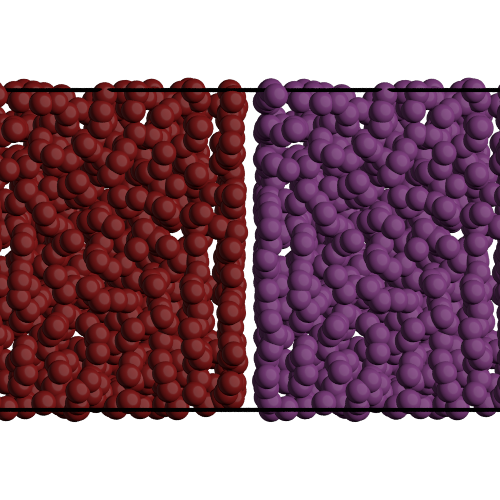

In [47]:
sim_viewer = FresnelGSD(gsd_file="weld.gsd", view_axis=(0, 1, 0), frame=0, height=12)
weld_colors = np.zeros_like(sim_viewer.positions)
weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
sim_viewer.colors = weld_colors
sim_viewer.view(width=500, height=500)

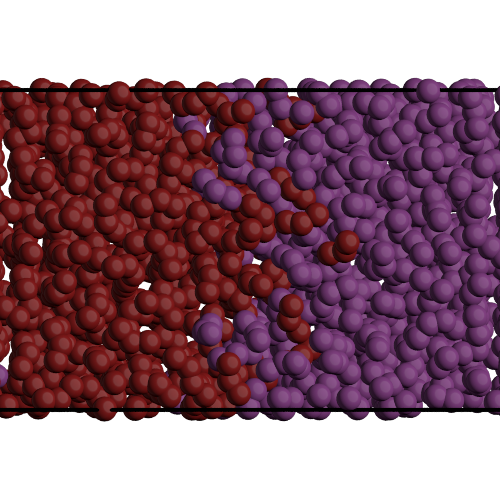

In [48]:
sim_viewer.frame = -1
sim_viewer.height = 12
sim_viewer.view_axis = (0, 1, 0)
sim_viewer.view(width=500, height=500)

In [49]:
# Running a tensile test simulation
from flowermd.library.simulations.tensile import Tensile
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)
    
tensile_sim = Tensile(
    initial_state="weld_restart.gsd",
    forcefield=hoomd_forces,
    tensile_axis=(1,0,0),
    gsd_file_name="tensile.gsd",
    gsd_write_freq=1000,
    log_file_name="tensile_log.txt",
    log_write_freq=500,
    fix_ratio=0.30,
    device = cpu
)
tensile_sim.run_tensile(n_steps=1e5, strain=0.50, period=500, kT=2.0, tau_kt=0.001)
tensile_sim.flush_writers()

**ERROR**: No pairs are defined.


Initializing simulation state from a GSD file.
Step 0 of 100001; TPS: 0.0; ETA: nan hours, nan minutes
Step 750 of 100001; TPS: 391.16; ETA: 4.2 minutes
Step 1500 of 100001; TPS: 408.64; ETA: 4.0 minutes
Step 2250 of 100001; TPS: 419.05; ETA: 3.9 minutes
Step 3000 of 100001; TPS: 431.37; ETA: 3.7 minutes
Step 3750 of 100001; TPS: 436.39; ETA: 3.7 minutes
Step 4500 of 100001; TPS: 437.3; ETA: 3.6 minutes
Step 5250 of 100001; TPS: 439.24; ETA: 3.6 minutes
Step 6000 of 100001; TPS: 444.05; ETA: 3.5 minutes
Step 6750 of 100001; TPS: 446.93; ETA: 3.5 minutes
Step 7500 of 100001; TPS: 448.53; ETA: 3.4 minutes
Step 8250 of 100001; TPS: 450.76; ETA: 3.4 minutes
Step 9000 of 100001; TPS: 452.79; ETA: 3.3 minutes
Step 9750 of 100001; TPS: 453.88; ETA: 3.3 minutes
Step 10500 of 100001; TPS: 453.46; ETA: 3.3 minutes
Step 11250 of 100001; TPS: 454.37; ETA: 3.3 minutes
Step 12000 of 100001; TPS: 455.14; ETA: 3.2 minutes
Step 12750 of 100001; TPS: 456.86; ETA: 3.2 minutes
Step 13500 of 100001; TPS: 4

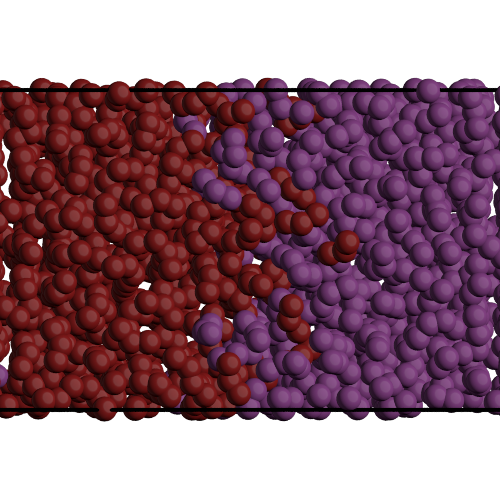

In [50]:
sim_viewer2 = FresnelGSD(gsd_file="tensile.gsd", view_axis=(0, 1, 0), frame=0, height=12)
weld_colors = np.zeros_like(sim_viewer2.positions)
weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
sim_viewer2.colors = weld_colors
sim_viewer2.view(width=500, height=500)